# **Load Packages**

In [1]:
# Library for utilities
import warnings
warnings.filterwarnings(action = 'ignore')

import numpy as np
import pandas as pd

# Library for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Library for model selection
from sklearn.model_selection import train_test_split

# Library for preprocessing and pipelines steps
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Library for feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Library for handling imbalanced data
from imblearn.over_sampling import SMOTE

# Library for building models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Library for compute metrics evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Library fot hyperparameter tuning
from sklearn.model_selection import KFold, GridSearchCV

# **Load Dataset**

In [2]:
# Load Credit Risk dataset
df_raw = pd.read_csv('Credit Risk.csv')

In [3]:
print('Show dataset:')
df_raw.head()

Show dataset:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print('Show information about dataset:')
df_raw.info()

Show information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                

# **Data Preparation and Exploration**

In [5]:
# Copy dataset
df_prep = df_raw.copy()

In [6]:
print(f'Show unique values based on feature \'id\'       : {df_prep['id'].nunique()}')
print(f'Show unique values based on feature \'member_id\': {df_prep['member_id'].nunique()}')

print(f'\nThe dataset contains {df_prep.duplicated().sum()} duplicated values')

Show unique values based on feature 'id'       : 466285
Show unique values based on feature 'member_id': 466285

The dataset contains 0 duplicated values


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Setelah dilakukan pemeriksaan terhadap keseluruhan dataset, <b>ditemukan bahwa tidak terdapat data duplikat</b> di dalamnya. Temuan ini mengindikasikan bahwa <b>setiap entri dalam dataset bersifat unik</b> dan merepresentasikan <b>satu individu secara spesifik</b> tanpa adanya pengulangan informasi.
</p>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Pada tahap selanjutnya, akan ditentukan fitur mana yang akan digunakan sebagai target dalam proses pemodelan. <b>Dalam hal ini, fitur</b> <code>loan_status</code> <b>dipilih sebagai target variabel</b>. Pemilihan ini didasarkan pada fungsi <code>loan_status</code> yang secara langsung merepresentasikan kondisi atau status akhir dari pinjaman yang diberikan, seperti apakah pinjaman tersebut telah lunas, masih berjalan, atau justru mengalami gagal bayar.
</p>

In [7]:
# Show data distribution in the loan_status feature
print('Show data distribution:')

df_prep['loan_status'].value_counts()

Show data distribution:


loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan distribusi data pada fitur <code>loan_status</code>, ditemukan bahwa data pinjaman terbagi ke dalam sembilan kategori yang mencerminkan berbagai kondisi pinjaman.
</p>

<ul style="font-family: 'Georgia', serif; text-align: justify; line-height: 1.5;">
  <li> <b>Current</b> menunjukkan bahwa pinjaman masih aktif dan pembayaran cicilan berjalan lancar sesuai jadwal. </li>

  <li> <b>Fully Paid</b> menunjukkan bahwa pinjaman telah dilunasi sepenuhnya oleh peminjam. </li>

  <li> <b>Charged Off</b> menunjukkan bahwa pinjaman telah dianggap tidak tertagih dan dihapuskan dari catatan sebagai kerugian. </li>

  <li> <b>Late (31-120 days)</b> menunjukkan bahwa pinjaman yang telah melewati batas jatuh tempo selama 31 hingga 120 hari. </li>

  <li> <b>In Grace Period</b> menunjukkan bahwa bahwa pinjaman sedang berada dalam masa tenggang setelah jatuh tempo, namun peminjam masih diberikan kesempatan untuk melakukan pembayaran tanpa dianggap menunggak. </li>

  <li> <b>Does not meet the credit policy. Status: Fully Paid</b> menunjukkan bahwa meskipun pinjaman telah lunas, pinjaman tersebut awalnya tidak memenuhi kebijakan kredit yang berlaku. </li>

  <li> <b>Late (16-30 days)</b> menunjukkan bahwa pinjaman yang telah melewati batas jatuh tempo selama 16 hingga 30 hari. </li>

  <li> <b>Default</b> menunjukkan bahwa pinjaman telah gagal bayar secara permanen dan dianggap sebagai kerugian. </li>

  <li> <b>Does not meet the credit policy. Status: Charge Off</b> menunjukkan bahwa pinjaman yang tidak memenuhi kebijakan kredit dan telah dihapuskan karena dianggap tidak tertagih. </li>
</ul>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan pemahaman terhadap masing-masing kategori pada fitur <code>loan_status</code>, maka untuk keperluan analisis dan pemodelan, fitur tersebut akan diklasifikasikan ke dalam dua nilai target utama, yaitu <b>good loan</b> dan <b>bad loan</b>. <b>Good loan mengacu pada pinjaman yang tidak bermasalah serta mencerminkan kinerja yang positif</b>, sedangkan <b>bad loan menggambarkan kondisi pinjaman yang berisiko atau mengalami kegagalan pembayaran</b>.
</p>

In [8]:
# Data transformation in the loan_status feature
list_of_good_category  = ['Current', 'Fully Paid', 'Does not meet the credit policy. Status: Fully Paid']
df_prep['loan_status'] = df_prep['loan_status'].apply(lambda val: 1 if val in list_of_good_category else 0)

# Note:
# 1 -> Good Loan
# 0 -> Bad  Loan

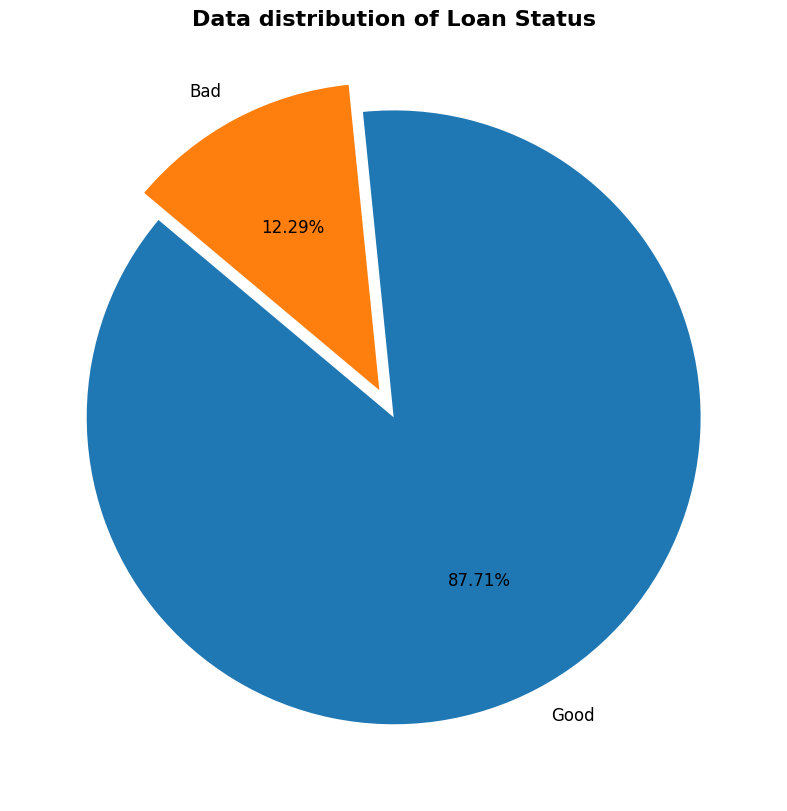

In [9]:
# Show data distribution visualization in the loan_status feature
plt.figure(figsize = (10,8), constrained_layout = True)

plt.pie(x = df_prep['loan_status'].value_counts(), explode = (0,0.1), labels = ['Good', 'Bad'], autopct = '%1.2f%%',
        startangle = 140, textprops = {'fontsize': 12})

plt.title('Data distribution of Loan Status', fontsize = 16, fontweight = 'bold')
plt.show()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Setelah menetapkan fitur yang akan digunakan sebagai target, langkah <b>selanjutnya adalah melakukan pembersihan data dengan menghapus fitur-fitur yang dianggap tidak relevan</b>. Fitur-fitur tersebut meliputi <b>kolom dengan nilai unik pada setiap entri</b>, <b>kolom yang seluruh isinya merupakan missing values</b>, serta <b>fitur yang bersifat redundan atau memiliki informasi ganda dengan fitur lainnya</b>, dan lain sebagainya. Proses ini penting dilakukan untuk memastikan bahwa hanya fitur-fitur yang bermakna dan berkontribusi terhadap pemodelan yang disertakan dalam analisis, sehingga dapat meningkatkan efisiensi dan akurasi model.
</p>

In [10]:
# Set features to drop
columns_to_drop = [
    # Features with unique values
    'id', 'member_id',
    # Features with all null values
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
    'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
    'inq_last_12m',
    # Feature with redundant values
    'sub_grade',
    # Unnecessary Features
    'Unnamed: 0', 'url', 'desc',
    # Features with constant values
    'policy_code', 'application_type',
    # Feature with censored personal values
    'zip_code'
]

# Drop features
df_prep = df_prep.drop(labels = columns_to_drop, axis = 1)

In [11]:
print(f'Show updated shape of dataset: {df_prep.shape}')

Show updated shape of dataset: (466285, 49)


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Selanjutnya, akan dilakukan proses transformasi data melalui teknik <b>feature engineering</b>. <b>Pada tahap ini, fokus transformasi diarahkan pada fitur-fitur yang mengandung data waktu</b>, yaitu <code>issue_d</code>, <code>earliest_cr_line</code>, <code>last_pymnt_d</code>, <code>next_pymnt_d</code>, dan <code>last_credit_pull_d</code>. <b>Tujuan dari tahap ini adalah untuk mengubah data waktu tersebut ke dalam format yang lebih informatif</b>, sehingga dapat memberikan <b>wawasan yang lebih mendalam dan relevan</b> terhadap analisis yang akan dilakukan.
</p>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Sebelum mengolah fitur tanggal (date), penting untuk menetapkan <b>snapshot date</b> sebagai tanggal referensi. <b>Snapshot date merupakan titik waktu tertentu yang digunakan sebagai acuan untuk memastikan bahwa seluruh data yang dianalisis merepresentasikan kondisi pada periode yang konsisten dan relevan</b>.
</p>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
<b>Dataset ini mencakup data dari tahun 2007 hingga 2014</b>. <b>Jika hanya mengacu pada periode tersebut, terdapat risiko bahwa data yang dihasilkan kurang merepresentasikan kondisi terkini maupun keseluruhan aktivitas pinjaman</b>. Terlebih lagi, pada fitur last_pymnt_d ditemukan bahwa <b>pembayaran terakhir oleh peminjam tercatat terjadi pada Januari 2016</b>. Oleh karena itu, <b>ditetapkan bahwa snapshot date yang digunakan adalah Januari 2017</b>, dengan pertimbangan bahwa <b>periode tersebut dipilih untuk memastikan seluruh transaksi, termasuk pembayaran terakhir dan aktivitas lainnya hingga akhir tahu, telah sepenuhnya tercatat dalam dataset</b>. Dengan demikian, analisis yang dilakukan dapat memberikan gambaran yang paling komprehensif dan akurat.
</p>

In [12]:
# Set a snapshot date
snapshot_date = pd.to_datetime('2017-01-01')
print(f'Snapshot date: {snapshot_date}')

Snapshot date: 2017-01-01 00:00:00


<ul style="font-family: 'Georgia', serif; text-align: justify; line-height: 1.5;">
  <li> Data pada fitur <code>issue_d</code>, <code>earliest_cr_line</code>, <code>last_pymnt_d</code>, <code>next_pymnt_d</code>, dan <code>last_credit_pull_d</code> akan ditransformasikan ke dalam format tanggal untuk memudahkan proses analisis dan pengolahan pada tahap-tahap selanjutnya. </li>

  <li> Selanjutnya, setelah seluruh fitur berhasil dikonversi ke dalam format tanggal, akan dilakukan perhitungan durasi pinjaman dengan memanfaatkan masing-masing fitur tersebut. <b>Perhitungan durasi ini bertujuan untuk mengetahui selisih waktu antara snapshot date dengan tanggal yang tercantum pada setiap fitur</b>, sehingga dapat memberikan gambaran mengenai <b>lamanya hubungan pinjaman, usia riwayat kredit, waktu sejak pembayaran terakhir, hingga jeda waktu menuju pembayaran berikutnya</b>. </li>
</ul>

In [13]:
print('Show data before perform data transformation:')

df_prep[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']].head()

Show data before perform data transformation:


,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,Dec-11,Jan-85,Jan-15,NaN,Jan-16
1,Dec-11,Apr-99,Apr-13,NaN,Sep-13
2,Dec-11,Nov-01,Jun-14,NaN,Jan-16
3,Dec-11,Feb-96,Jan-15,NaN,Jan-15
4,Dec-11,Jan-96,Jan-16,Feb-16,Jan-16


In [14]:
# Data transformation on features that contain date information
columns_to_transform = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

for column in columns_to_transform:
    df_prep[column] = pd.to_datetime(df_prep[column], format = f'%b-%y', errors = 'ignore')

In [15]:
print('Show data after perform data transformation:')

df_prep[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']].head()

Show data after perform data transformation:


,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,NaT,2016-01-01
1,2011-12-01,1999-04-01,2013-04-01,NaT,2013-09-01
2,2011-12-01,2001-11-01,2014-06-01,NaT,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01,NaT,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-02-01,2016-01-01


In [16]:
# Define function to calculate the difference between snapshot date and each time data
def compute_difference(snapshot_date, date):
    year_difference = snapshot_date.year - date.year

    duration_in_months = year_difference * 12 + (snapshot_date.month - date.month)
    return duration_in_months

In [17]:
# Apply the function by creating new features
columns_to_compute = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

for column in columns_to_compute:
    df_prep['months_since_' + column] = df_prep[column].apply(lambda val: compute_difference(snapshot_date, val))

In [18]:
print('Show summary of statistics:')

df_prep[['months_since_issue_d', 'months_since_earliest_cr_line', 'months_since_last_pymnt_d', 'months_since_next_pymnt_d',
         'months_since_last_credit_pull_d']].describe().T

Show summary of statistics:


,count,mean,std,min,25%,50%,75%,max
months_since_issue_d,466285.0,40.255187,14.340154,25.0,30.0,36.0,46.0,115.0
months_since_earliest_cr_line,466256.0,228.482430,93.974829,-623.0,172.0,214.0,274.0,576.0
months_since_last_pymnt_d,465909.0,20.294369,12.809898,12.0,12.0,13.0,24.0,109.0
months_since_next_pymnt_d,239071.0,11.738136,6.082298,10.0,11.0,11.0,11.0,109.0
months_since_last_credit_pull_d,466243.0,16.045588,9.636423,12.0,12.0,12.0,14.0,116.0


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Ditemukan nilai negatif pada fitur <code>months_since_earliest_cr_line</code>, padahal kondisi tersebut seharusnya tidak terjadi. Hal ini dianggap tidak wajar karena secara logis <b>karena tanggal awal dimulainya kredit (earliest credit line) seharusnya selalu berada sebelum snapshot date</b>, sehingga <b>selisih waktu yang dihitung seharusnya bernilai positif atau nol</b>. Oleh karena itu, diperlukan pengecekan lebih lanjut untuk memastikan kebenaran data tersebut.
</p>

In [19]:
df_prep[df_prep['months_since_earliest_cr_line'] < 0][['earliest_cr_line', 'months_since_earliest_cr_line']].head()

,earliest_cr_line,months_since_earliest_cr_line
1580,2062-09-01,-548.0
1770,2068-09-01,-620.0
2799,2064-09-01,-572.0
3282,2067-09-01,-608.0
3359,2065-02-01,-577.0


In [20]:
# Compute the percentage of error values
percentage_err = (df_prep[df_prep['months_since_earliest_cr_line'] < 0].shape[0] / df_prep.shape[0]) * 100
print(f'Percentage of error values: {percentage_err:.2f}%')

Percentage of error values: 0.25%


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Setelah dilakukan pengecekan lebih lanjut, diketahui bahwa <b>nilai negatif pada fitur</b> <code>months_since_earliest_cr_line</code> <b>disebabkan oleh kesalahan program dalam membaca format tahun</b>. Seharusnya, beberapa data yang berasal dari tahun 1900-an justru terbaca sebagai tahun 2000-an saat proses konversi, sehingga menghasilkan selisih negatif terhadap snapshot date. <b>Mengingat nilai-nilai tersebut tidak mencerminkan kondisi sebenarnya dan hanya mencakup sekitar 0,25 persen dari total data</b>, maka diputuskan untuk <b>menghapus data tersebut guna menjaga kualitas dan keakuratan analisis</b>.
</p>

In [21]:
df_prep = df_prep.drop(df_prep[df_prep['months_since_earliest_cr_line'] < 0].index, axis = 0).reset_index(drop = True)

In [22]:
print('Show summary of statistics after drop the error values:')

df_prep[['months_since_issue_d', 'months_since_earliest_cr_line', 'months_since_last_pymnt_d', 'months_since_next_pymnt_d',
         'months_since_last_credit_pull_d']].describe().T

Show summary of statistics after drop the error values:


,count,mean,std,min,25%,50%,75%,max
months_since_issue_d,465116.0,40.259073,14.342403,25.0,30.0,36.0,46.0,115.0
months_since_earliest_cr_line,465087.0,230.519182,84.822883,62.0,172.0,214.0,274.0,576.0
months_since_last_pymnt_d,464741.0,20.298151,12.812808,12.0,12.0,13.0,24.0,109.0
months_since_next_pymnt_d,238390.0,11.738521,6.083252,10.0,11.0,11.0,11.0,109.0
months_since_last_credit_pull_d,465075.0,16.045969,9.636585,12.0,12.0,12.0,14.0,116.0


In [23]:
# Drop unnecessary features
columns_to_drop = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
df_prep = df_prep.drop(columns_to_drop, axis = 1)

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Sebelum melangkah ke tahap pemodelan, akan dilakukan <b>pemeriksaan distribusi data pada fitur-fitur bertipe kategorikal</b>. <b>Tujuan dari proses ini adalah untuk memahami sebaran data pada setiap kategori</b> serta <b>mengidentifikasi frekuensi atau proporsi masing-masing kategori</b> dalam dataset.
</p>

In [24]:
print('Show the data distribution of each categorical feature type:')

for column in df_prep.select_dtypes(include = 'object'):
    print(df_prep[column].value_counts())
    print('=================================================')

Show the data distribution of each categorical feature type:
term
36 months    337087
60 months    128029
Name: count, dtype: int64
grade
B    136550
C    124987
D     76730
A     74631
E     35687
F     13213
G      3318
Name: count, dtype: int64
emp_title
Teacher                                     5388
Manager                                     4433
Registered Nurse                            2314
RN                                          2203
Supervisor                                  1964
                                            ... 
natales auto                                   1
United States Infrastructure Corporation       1
Nucor Building Systems                         1
John Wiley Jr.                                 1
Southern Star Photography                      1
Name: count, Length: 205223, dtype: int64
emp_length
10+ years    149706
2 years       41321
3 years       36548
< 1 year      36213
5 years       30727
1 year        29590
4 years       27982
7 years   

<ul style="font-family: 'Georgia', serif; text-align: justify; line-height: 1.5;">
  <li> Ditemukan bahwa dua fitur, yaitu <code>term</code> dan <code>emp_length</code>, memiliki format yang kurang sesuai karena seharusnya <b>dinyatakan dalam bentuk numerik</b>. Oleh karena itu, <b>keduanya akan ditransformasi melalui teknik feature engineering</b> agar lebih mudah dianalisis dan dapat memberikan kontribusi yang lebih optimal dalam pemodelan. </li>

  <li> Selanjutnya, terdapat tiga fitur lainnya, yaitu <code>emp_title</code>, <code>title</code>, dan <code>addr_state</code>, yang memiliki <b>jumlah kategori yang sangat beragam</b>, sehingga berisiko menyebabkan <b>overfitting atau kompleksitas model yang tidak perlu</b>. Selain itu, fitur <code>pymnt_plan</code> menunjukkan <b>distribusi kategori yang sangat tidak seimbang</b>, yang dapat mengganggu stabilitas model. <b>Demi menjaga kualitas data dan kinerja model yang optimal, keempat fitur tersebut diputuskan untuk dihapus dari dataset</b>. </li>
</ul>

In [25]:
print('Show unique values in the term feature:')
df_prep['term'].unique()

Show unique values in the term feature:


array([' 36 months', ' 60 months'], dtype=object)

In [26]:
# Create new feature
df_prep['term_months'] = df_prep['term'].str.replace(' months', '').str.strip().astype('int')

In [27]:
df_prep[['term', 'term_months']].head()

,term,term_months
0,36 months,36
1,60 months,60
2,36 months,36
3,36 months,36
4,60 months,60


In [28]:
print('Show unique values in the emp_length feature:')
df_prep['emp_length'].unique()

Show unique values in the emp_length feature:


array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [29]:
# Create new feature
df_prep['emp_length_int'] = df_prep['emp_length']

df_prep['emp_length_int'] = df_prep['emp_length_int'].str.replace('< 1 year', str(0))
df_prep['emp_length_int'] = df_prep['emp_length_int'].str.replace('10\+ years', '10', regex = True)
df_prep['emp_length_int'] = df_prep['emp_length_int'].str.replace(' years?', '', regex = True)

df_prep['emp_length_int'] = df_prep['emp_length_int'].str.strip().astype('float')

In [30]:
df_prep[['emp_length', 'emp_length_int']].head()

,emp_length,emp_length_int
0,10+ years,10.0
1,< 1 year,0.0
2,10+ years,10.0
3,10+ years,10.0
4,1 year,1.0


In [31]:
# Drop unnecessary features
columns_to_drop = ['emp_title', 'title', 'addr_state', 'pymnt_plan', 'term', 'emp_length']
df_prep = df_prep.drop(columns_to_drop, axis = 1)

In [32]:
print(f'Show updated shape of dataset: {df_prep.shape}')

Show updated shape of dataset: (465116, 45)


In [33]:
print('Show updated dataset:')
df_prep.head()

Show updated dataset:


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,months_since_issue_d,months_since_earliest_cr_line,months_since_last_pymnt_d,months_since_next_pymnt_d,months_since_last_credit_pull_d,term_months,emp_length_int
0,5000,5000,4975.0,10.65,162.87,B,RENT,24000.0,Verified,1,...,NaN,NaN,NaN,61,384.0,24.0,NaN,12.0,36,10.0
1,2500,2500,2500.0,15.27,59.83,C,RENT,30000.0,Source Verified,0,...,NaN,NaN,NaN,61,213.0,45.0,NaN,40.0,60,0.0
2,2400,2400,2400.0,15.96,84.33,C,RENT,12252.0,Not Verified,1,...,NaN,NaN,NaN,61,182.0,31.0,NaN,12.0,36,10.0
3,10000,10000,10000.0,13.49,339.31,C,RENT,49200.0,Source Verified,1,...,NaN,NaN,NaN,61,251.0,24.0,NaN,24.0,36,10.0
4,3000,3000,3000.0,12.69,67.79,B,RENT,80000.0,Source Verified,1,...,NaN,NaN,NaN,61,252.0,12.0,11.0,12.0,60,1.0


# **Data Visualization - Insights**

In [34]:
# Copy dataset
df_visual = df_prep.copy()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Pada tahap visualisasi data, <b>fitur</b> <code>loan_amnt</code> menjadi fokus utama analisis karena fitur ini merepresentasikan <b>besarnya nilai pinjaman yang diajukan oleh peminjam</b>, yang merupakan indikator fundamental dalam <b>penilaian risiko kredit</b>.
</p>

## **Credit Stack Risk Analysis**

In [35]:
# Create new feature
df_visual['loan_amnt_bin'] = pd.qcut(x = df_visual['loan_amnt'], q = 3, labels = ['Low Loan', 'Medium Loan', 'High Loan'])

In [36]:
# Create new feature
df_visual['revol_bal_share'] = df_visual['revol_bal'] / (df_visual['loan_amnt'] + df_visual['revol_bal'])

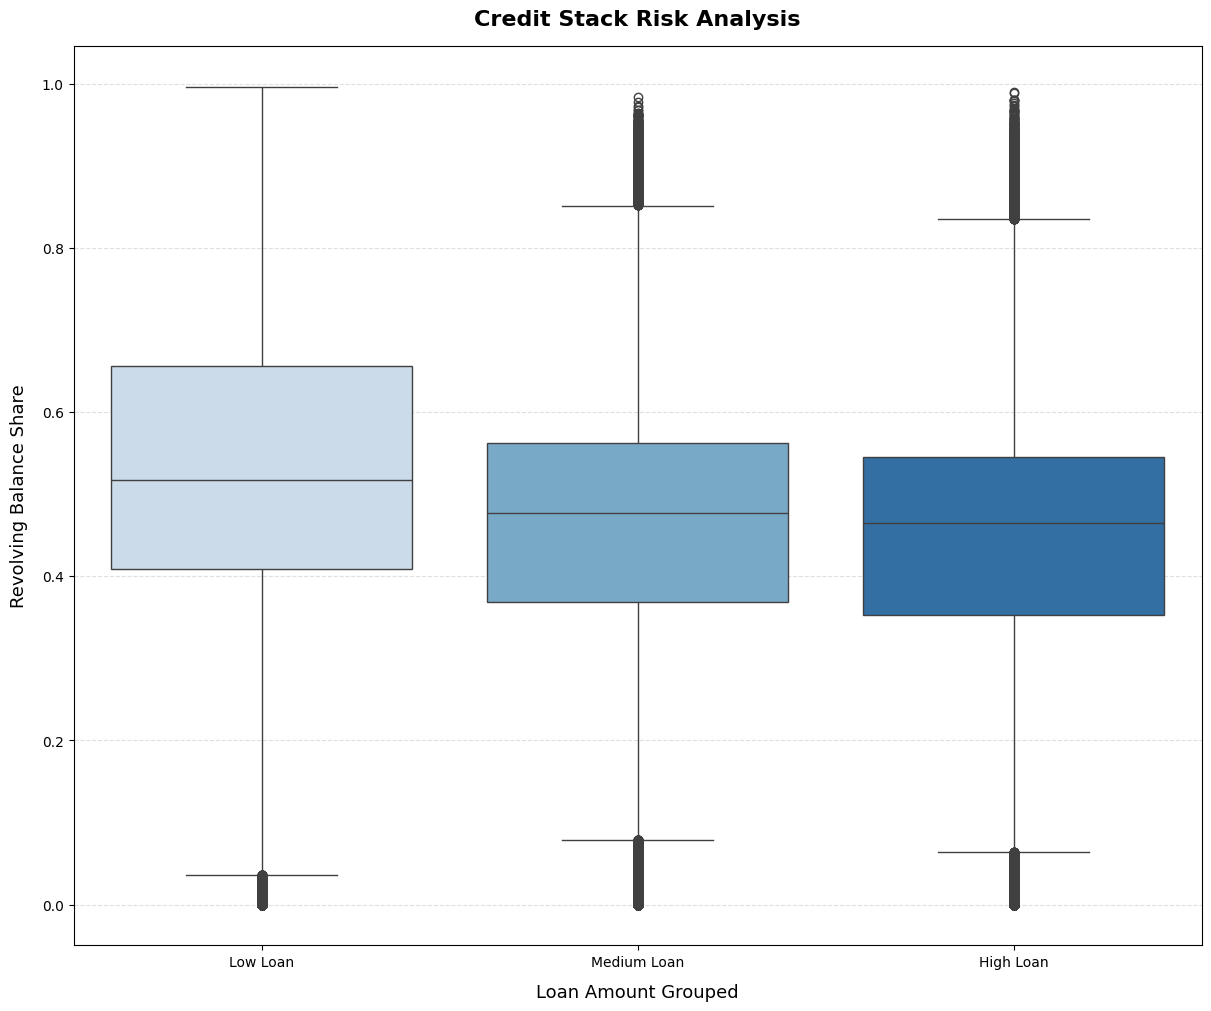

In [37]:
# Set the figure
plt.figure(figsize = (12,10), constrained_layout = True)

# Create a plot
sns.boxplot(data = df_visual, x = 'loan_amnt_bin', y = 'revol_bal_share', palette = 'Blues')

# Add the title and labels
plt.title('Credit Stack Risk Analysis', pad = 15, fontsize = 16, fontweight = 'bold')

plt.xlabel('Loan Amount Grouped'    , labelpad = 10, fontsize = 13)
plt.ylabel('Revolving Balance Share', labelpad = 10, fontsize = 13)

# Set the grid
plt.grid(axis = 'y', linestyle = '--', alpha = 0.4)

# Show the plot
plt.show()

## **Principal Paid Ratio**

In [38]:
# Create new feature
df_visual['prncp_paid_ratio'] = df_visual['total_rec_prncp'] / df_visual['loan_amnt']

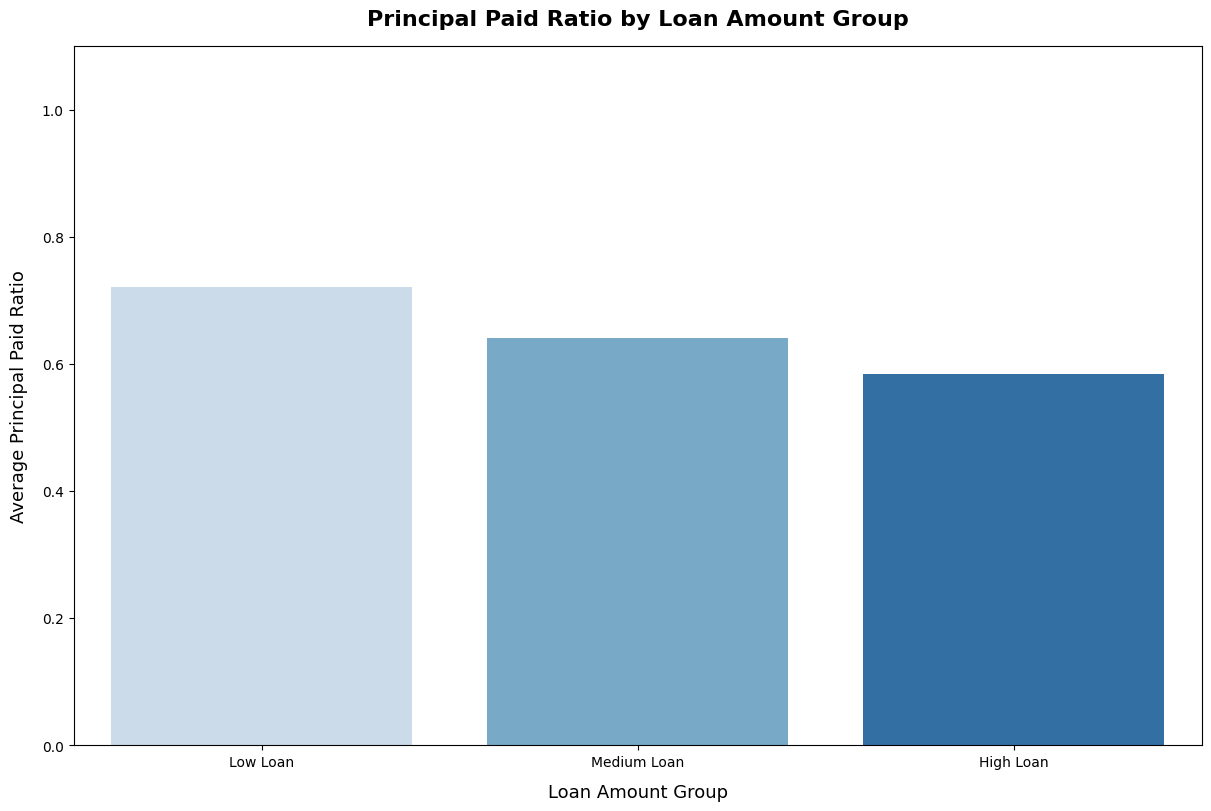

In [39]:
prncp_paid_ratio_by_loan_bin = df_visual.groupby('loan_amnt_bin')['prncp_paid_ratio'].mean().reset_index()

# Set the figure
plt.figure(figsize = (12,8), constrained_layout = True)

# Create a plot
sns.barplot(data = prncp_paid_ratio_by_loan_bin, x = 'loan_amnt_bin', y = 'prncp_paid_ratio', palette = 'Blues')

# Add the title and labels
plt.title('Principal Paid Ratio by Loan Amount Group', pad = 15, fontsize = 16, fontweight = 'bold')

plt.xlabel('Loan Amount Group'           , labelpad = 10, fontsize = 13)
plt.ylabel('Average Principal Paid Ratio', labelpad = 10, fontsize = 13)

# Set another parameters
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.ylim(0, 1.1)

# Show the plot
plt.show()

## **Employment Risk Mapping**

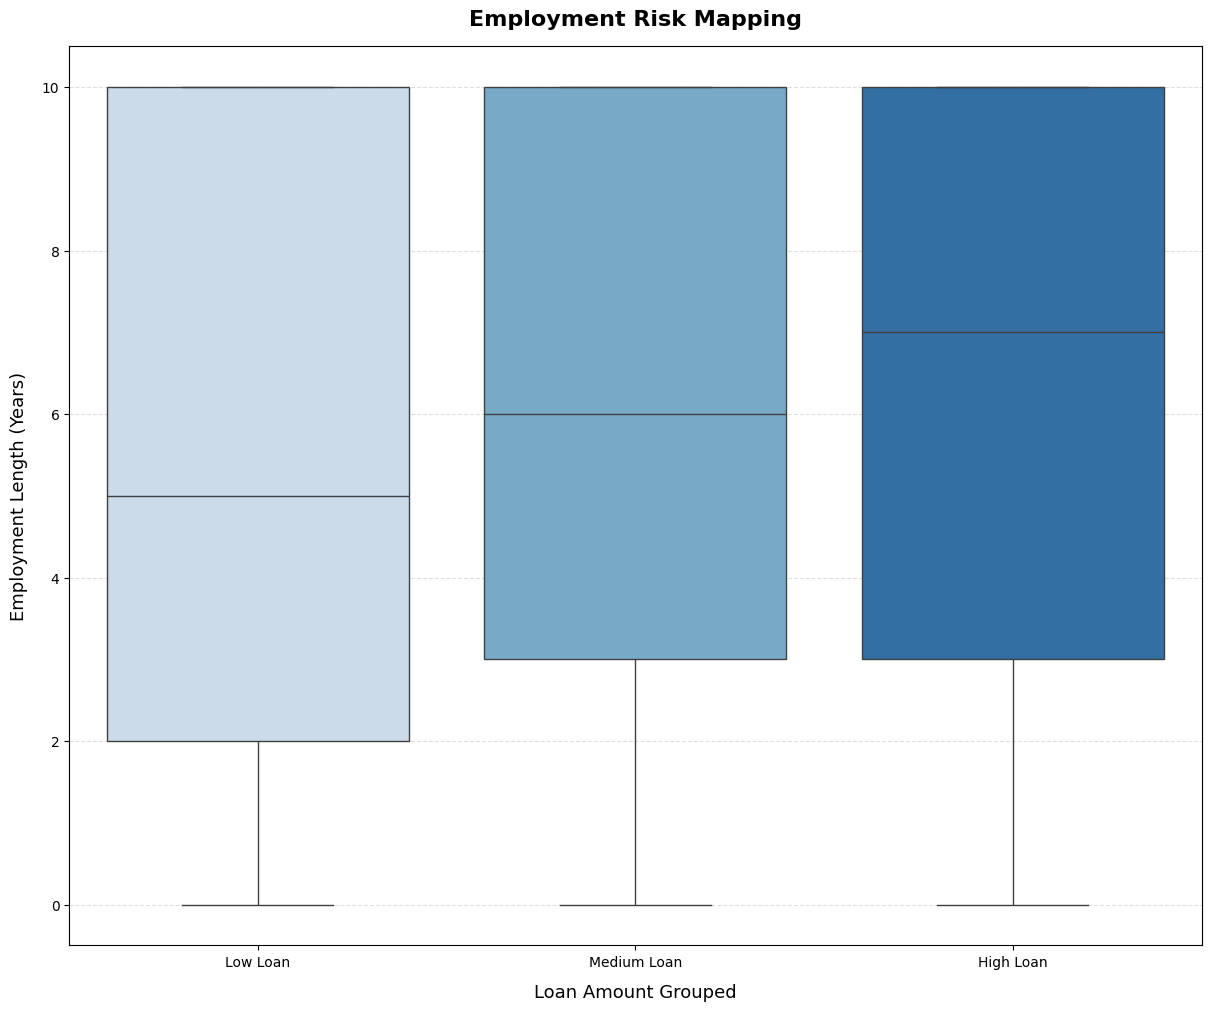

In [40]:
# Set the figure
plt.figure(figsize = (12,10), constrained_layout = True)

# Create a plot
sns.boxplot(data = df_visual, x = 'loan_amnt_bin', y = 'emp_length_int', palette = 'Blues')

# Add the title and labels
plt.title('Employment Risk Mapping', pad = 15, fontsize = 16, fontweight = 'bold')

plt.xlabel('Loan Amount Grouped'      , labelpad = 10, fontsize = 13)
plt.ylabel('Employment Length (Years)', labelpad = 10, fontsize = 13)

# Set the grid
plt.grid(axis = 'y', linestyle = '--', alpha = 0.4)

# Show the plot
plt.show()

# **Data Preparation and Exploration**

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Selanjutnya, akan dilakukan <b>analisis korelasi antar fitur</b> untuk mendeteksi kemungkinan adanya <b>multikolinearitas</b> dalam data. Langkah ini penting untuk memastikan bahwa <b>tidak terdapat hubungan linier yang terlalu kuat antar fitur</b>, karena hal tersebut dapat <b>mempengaruhi akurasi dan kestabilan model</b> yang akan dibangun.
</p>

In [41]:
# Get feature with numerical type
selected_columns = df_prep.select_dtypes(include = 'number').columns.to_list()

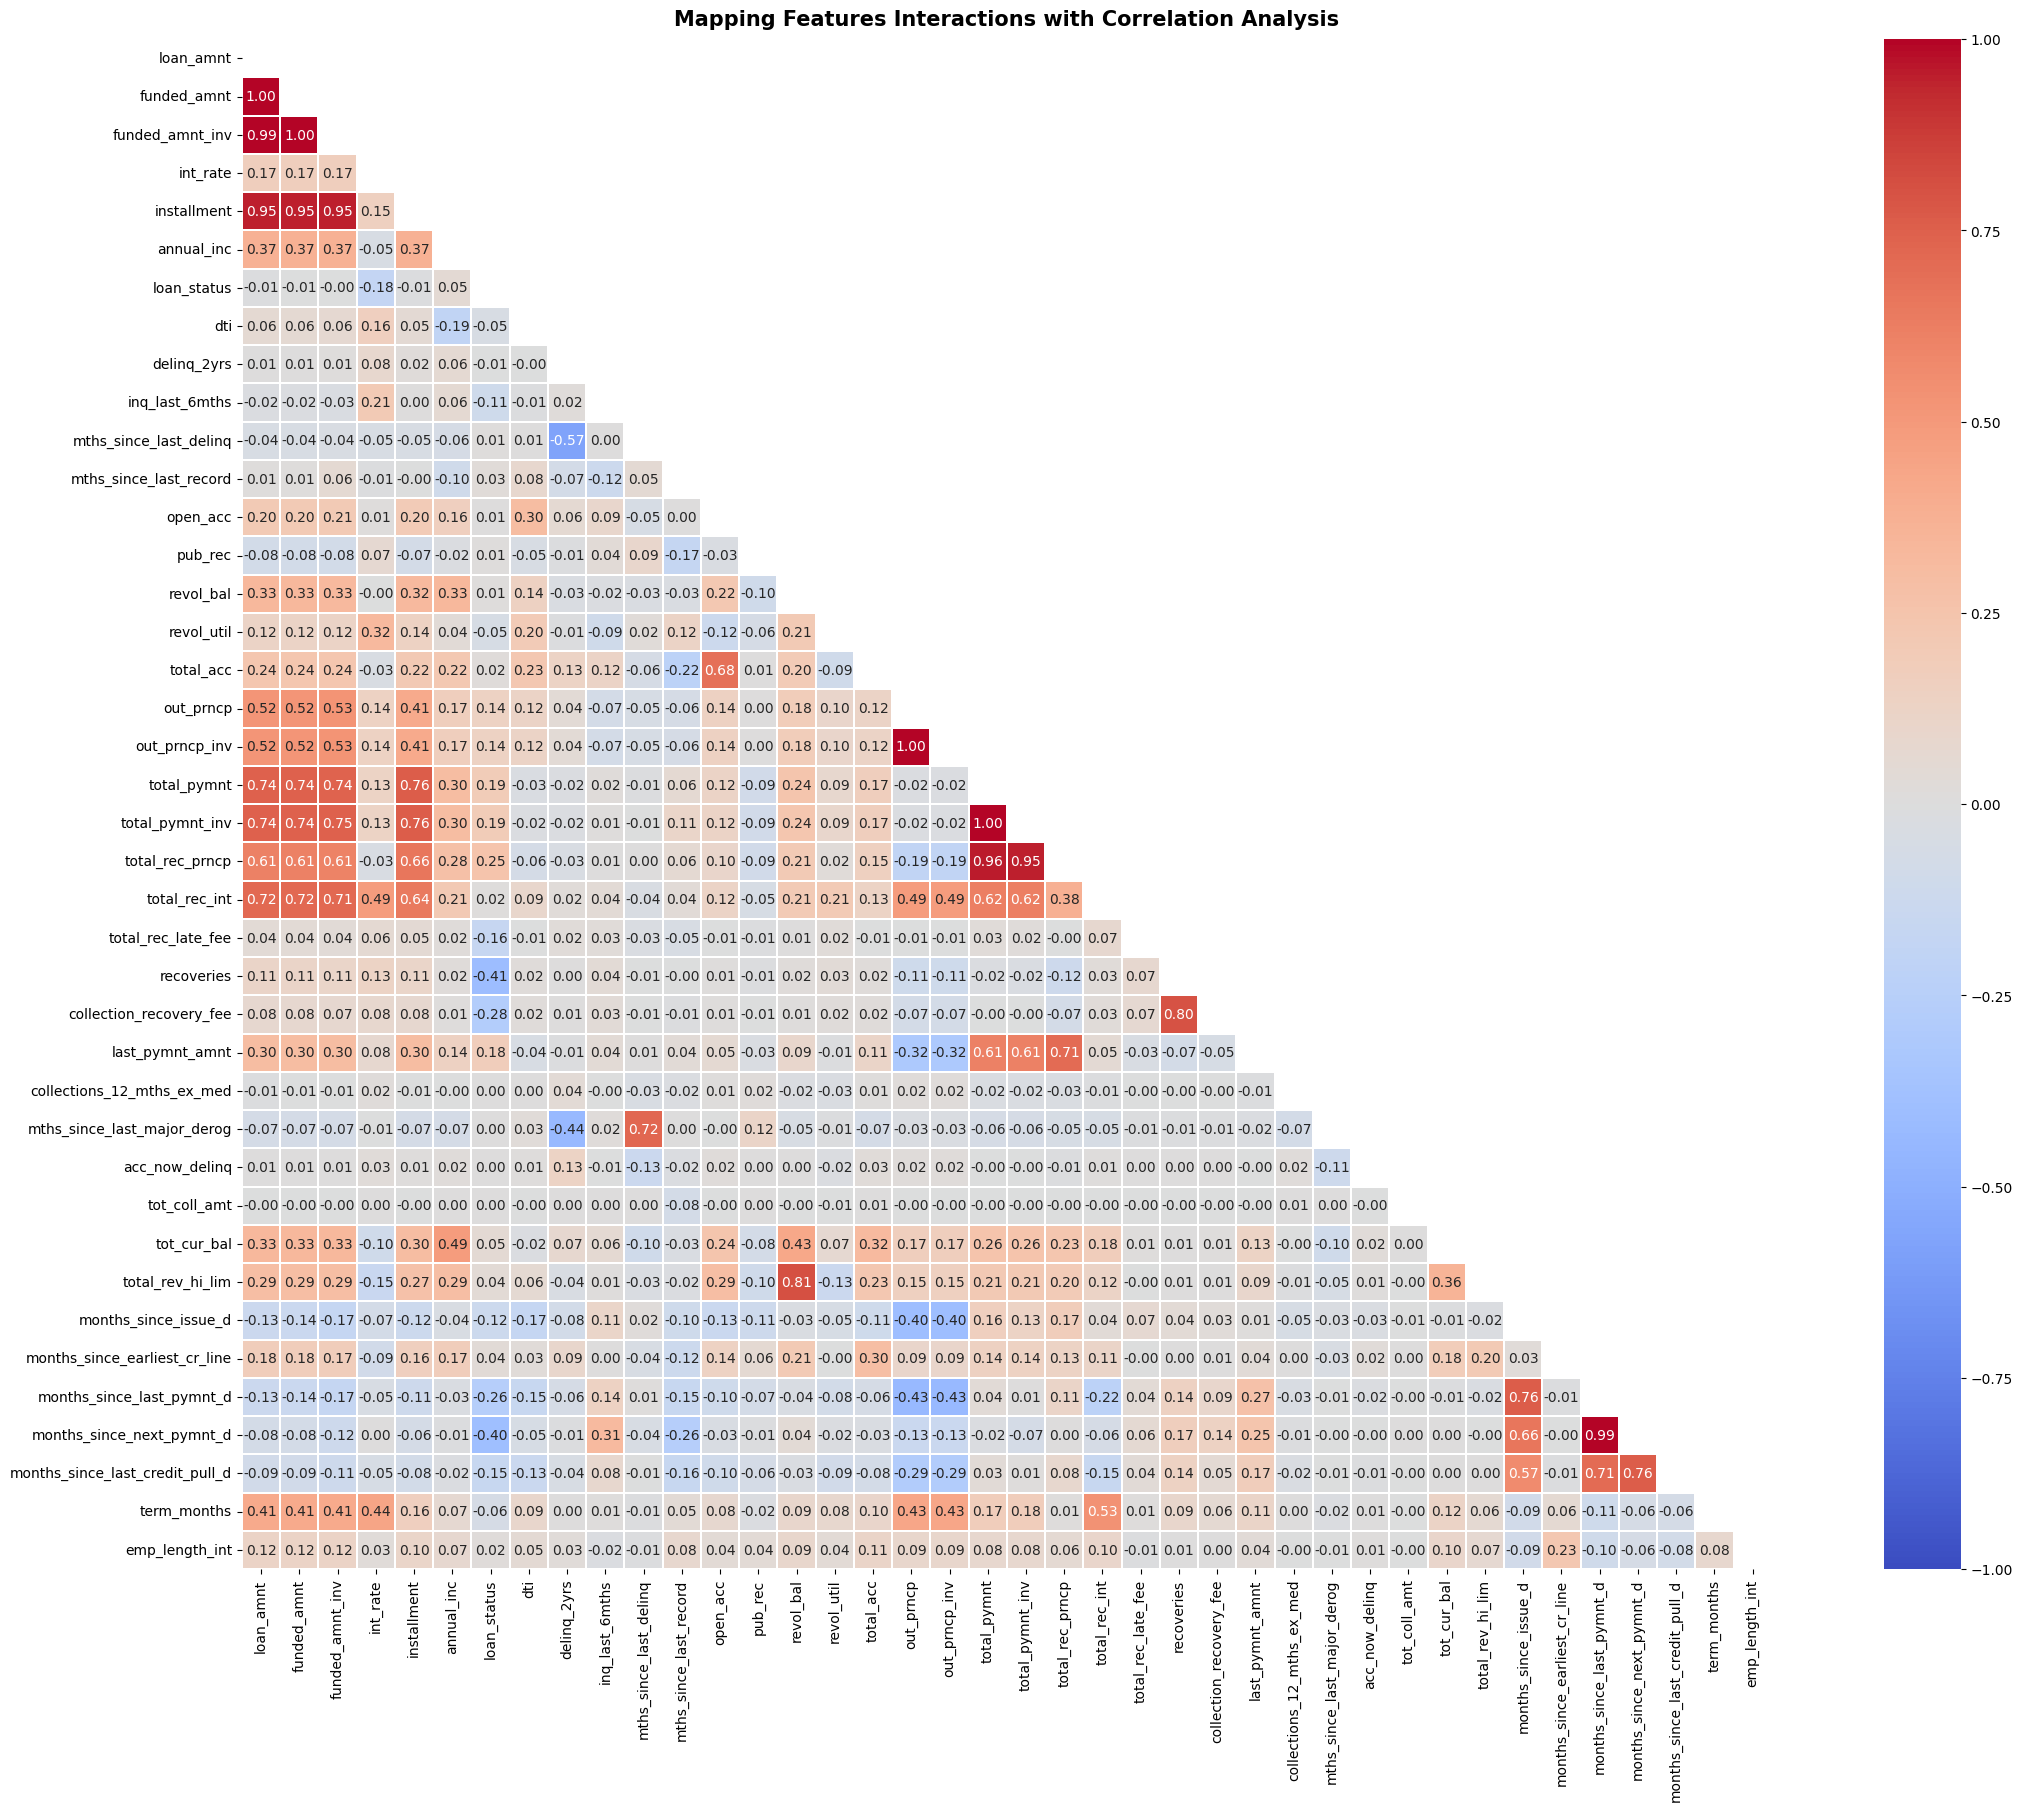

In [42]:
# Show the correlation value of each feature
df_corr = df_prep[selected_columns].corr()

mask = np.triu(np.ones_like(df_corr, dtype = bool))
plt.figure(figsize = (25,18), constrained_layout = True)

sns.heatmap(data = df_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, fmt = '.2f', linewidths = 0.3, square = True, mask = mask)

plt.title(label = 'Mapping Features Interactions with Correlation Analysis', pad = 10, fontsize = 15, fontweight = 'bold')

plt.show()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Ditemukan bahwa sejumlah fitur memiliki <b>nilai korelasi lebih dari 0.7 terhadap fitur lainnya</b>. Korelasi yang tinggi ini mengindikasikan adanya <b>redundansi informasi</b>, di mana fitur-fitur tersebut <b>merepresentasikan data yang serupa</b>. Kondisi ini berpotensi menimbulkan <b>multikolinearitas</b>, yang dapat <b>mengganggu kinerja dan interpretasi model</b>. Oleh karena itu, <b>fitur-fitur dengan korelasi tinggi diputuskan untuk dihapus dari dataset</b>. <b>Ambang batas 0.7</b> digunakan karena secara umum dianggap cukup kuat untuk menunjukkan adanya hubungan linier yang signifikan antar fitur, sehingga fitur dengan korelasi di atas nilai tersebut dinilai layak dihilangkan demi menjaga <b>efektivitas</b> dan <b>stabilitas model</b>.
</p>

In [43]:
# Compute the correlation values
df_corr = df_prep[selected_columns].corr().abs()

# Get features with a correlation value greater than 0.7
mask = np.triu(np.ones(df_corr.shape), k = 1).astype(np.bool)
upper = df_corr.where(mask)

columns_to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features
df_prep = df_prep.drop(columns_to_drop, axis = 1)

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Setelah mengatasi <b>masalah multikolinearitas</b> pada fitur-fitur yang terdeteksi, langkah selanjutnya adalah melakukan <b>pengecekan terhadap missing values pada setiap fitur</b>. Proses ini penting untuk memastikan bahwa <b>seluruh fitur yang akan digunakan dalam analisis bebas dari nilai yang hilang</b>  karena keberadaan missing values dapat <b>mengganggu proses pelatihan model dan menurunkan kualitas prediksi</b>.
</p>

In [44]:
# Define function to show the number of missing values
def display_missing(df):
    for column in df.columns.to_list():
        print(f'Number of missing values in the {column} feature is {df[column].isnull().sum()}')

In [45]:
print('Show number of missing values:')
display_missing(df_prep)

Show number of missing values:
Number of missing values in the loan_amnt feature is 0
Number of missing values in the int_rate feature is 0
Number of missing values in the grade feature is 0
Number of missing values in the home_ownership feature is 0
Number of missing values in the annual_inc feature is 4
Number of missing values in the verification_status feature is 0
Number of missing values in the loan_status feature is 0
Number of missing values in the purpose feature is 0
Number of missing values in the dti feature is 0
Number of missing values in the delinq_2yrs feature is 29
Number of missing values in the inq_last_6mths feature is 29
Number of missing values in the mths_since_last_delinq feature is 249827
Number of missing values in the mths_since_last_record feature is 402767
Number of missing values in the open_acc feature is 29
Number of missing values in the pub_rec feature is 29
Number of missing values in the revol_bal feature is 0
Number of missing values in the revol_ut

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Ditemukan bahwa terdapat sejumlah fitur yang memiliki <b>missing values dalam jumlah signifikan</b>. Untuk menjaga <b>kualitas</b> dan <b>integritas analisis</b>, diputuskan bahwa <b>fitur-fitur dengan persentase missing values lebih dari 50% akan dihapus dari dataset</b>. Keputusan ini diambil karena <b>imputasi terhadap fitur dengan tingkat kehilangan data yang tinggi berisiko memperkenalkan bias</b>, yang pada akhirnya dapat <b>menurunkan akurasi dan keandalan model</b>. Sementara itu, untuk <b>fitur-fitur dengan persentase missing values di bawah 50%</b> akan diterapkan <b>teknik imputasi menggunakan nilai median</b>. <b>Median dipilih karena mampu mengatasi pengaruh pencilan (outlier)</b> yang sering kali dapat memengaruhi hasil jika menggunakan rata-rata sebagai imputasi.
</p>

In [46]:
# Drop features with a missing value percentage is greater than 0.5
threshold = 0.50
df_prep = df_prep.loc[:, df_prep.isnull().mean() < threshold]

In [48]:
# Handling missing values
columns_to_imputate = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
                       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'months_since_earliest_cr_line',
                       'emp_length_int']

for column in columns_to_imputate:
    df_prep[column] = df_prep[column].fillna(df_prep[column].median())

In [49]:
print('Show number of missing values after handling:')
display_missing(df_prep)

Show number of missing values after handling:
Number of missing values in the loan_amnt feature is 0
Number of missing values in the int_rate feature is 0
Number of missing values in the grade feature is 0
Number of missing values in the home_ownership feature is 0
Number of missing values in the annual_inc feature is 0
Number of missing values in the verification_status feature is 0
Number of missing values in the loan_status feature is 0
Number of missing values in the purpose feature is 0
Number of missing values in the dti feature is 0
Number of missing values in the delinq_2yrs feature is 0
Number of missing values in the inq_last_6mths feature is 0
Number of missing values in the open_acc feature is 0
Number of missing values in the pub_rec feature is 0
Number of missing values in the revol_bal feature is 0
Number of missing values in the revol_util feature is 0
Number of missing values in the total_acc feature is 0
Number of missing values in the initial_list_status feature is 0

In [50]:
print('Show the latest updated of dataset:')
df_prep.head()

Show the latest updated of dataset:


,loan_amnt,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,months_since_issue_d,months_since_earliest_cr_line,term_months,emp_length_int
0,5000,10.65,B,RENT,24000.0,Verified,1,credit_card,27.65,0.0,...,0.00,0.00,0.0,0.0,0.0,81559.5,61,384.0,36,10.0
1,2500,15.27,C,RENT,30000.0,Source Verified,0,car,1.00,0.0,...,0.00,117.08,0.0,0.0,0.0,81559.5,61,213.0,60,0.0
2,2400,15.96,C,RENT,12252.0,Not Verified,1,small_business,8.72,0.0,...,0.00,0.00,0.0,0.0,0.0,81559.5,61,182.0,36,10.0
3,10000,13.49,C,RENT,49200.0,Source Verified,1,other,20.00,0.0,...,16.97,0.00,0.0,0.0,0.0,81559.5,61,251.0,36,10.0
4,3000,12.69,B,RENT,80000.0,Source Verified,1,other,17.94,0.0,...,0.00,0.00,0.0,0.0,0.0,81559.5,61,252.0,60,1.0


In [51]:
print(f'Show the latest updated shape of dataset: {df_prep.shape}')

Show the latest updated shape of dataset: (465116, 28)


In [52]:
# Separate features and labels
X = df_prep.drop('loan_status', axis = 1)
y = df_prep['loan_status']

In [53]:
# Separate training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23, stratify = y)

In [54]:
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')
print()
print(f'Shape of X_test  : {X_test.shape}')
print(f'Shape of y_test  : {y_test.shape}')

Shape of X_train : (372092, 27)
Shape of y_train : (372092,)

Shape of X_test  : (93024, 27)
Shape of y_test  : (93024,)


<ul style="font-family: 'Georgia', serif; text-align: justify; line-height: 1.5;">
  <li> Proses pengolahan data dilanjutkan dengan tahapan <b>encoding</b> dan <b>standarisasi</b>. Untuk encoding, digunakan dua teknik sesuai karakteristik fitur, yaitu <b>Label Encoder</b> untuk fitur biner dan <b>One-Hot Encoder</b> untuk fitur dengan lebih dari dua kategori, agar setiap kategori direpresentasikan secara unik dalam bentuk vektor biner. </li>

  <li> Selanjutnya, data numerik distandarisasi menggunakan <b>Robust Scaler</b>, yang mengandalkan median dan IQR dalam transformasinya. <b>Metode ini dipilih karena lebih tahan terhadap outlier</b>, sesuai dengan karakteristik distribusi numerik dalam dataset yang tidak normal dan mengandung pencilan. </li>

  <li> Setelah semua fitur berada dalam format dan skala yang sesuai, dilakukan <b>feature selection</b> menggunakan teknik <code>f_classif</code> untuk mengevaluasi hubungan antara masing-masing fitur dan variabel target, dengan tujuan meningkatkan efisiensi dan kinerja model. </li>
</ul>

In [55]:
# Set numerical and categorical features
columns_binary     = ['initial_list_status']
columns_non_binary = ['grade', 'home_ownership', 'verification_status', 'purpose']

columns_numeric    = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()

In [56]:
# Define pipeline for data preprocessing
def encoder_2d(column):
    LE = LabelEncoder()
    encoder = LE.fit_transform(column)

    return encoder.reshape(-1,1)

label_encoder  = FunctionTransformer(encoder_2d, validate = False)

preprocessor = ColumnTransformer(
    transformers = [
        ('onehot_encoder' , OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), columns_non_binary),
        ('label_encoder'  , label_encoder, columns_binary),
        ('scaler', 'passthrough', columns_numeric)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('features_selector', SelectKBest(score_func = f_classif, k = 20)),
    ('scaler', RobustScaler())
])

In [57]:
# Fit and transform the train data
X_train_processed = pipeline.fit_transform(X_train, y_train)

# Transform the test data
X_test_processed  = pipeline.transform(X_test)

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
langkah selanjutnya adalah menangani ketidakseimbangan kelas pada variabel target menggunakan <b>SMOTE (Synthetic Minority Over-sampling Technique)</b>. Metode ini menghasilkan sampel sintetis untuk <b>kelas minoritas</b>, sehingga distribusi kelas menjadi lebih seimbang dan model dapat mengenali pola dari kedua kelas secara lebih optimal.
</p>

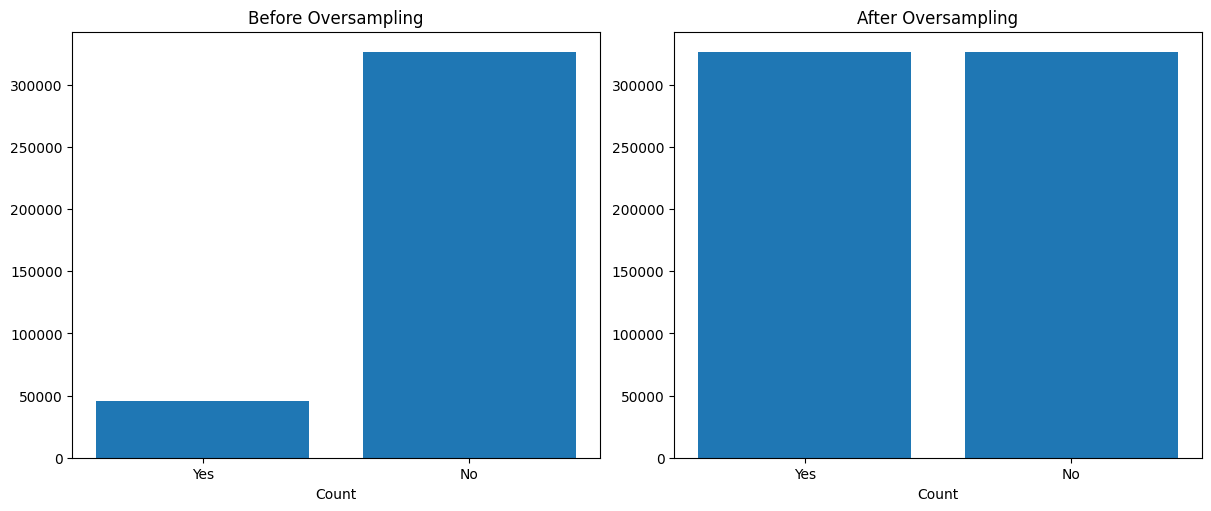

In [58]:
# Set the constant variable
OVERSAMPLE = SMOTE(random_state = 23)

# Handling imbalanced data
X_train_oversampling, y_train_oversampling = OVERSAMPLE.fit_resample(X_train_processed, y_train)

# Set the parameters
count_class_before = pd.Series(y_train).value_counts()
count_class_after  = pd.Series(y_train_oversampling).value_counts()

# Set the figure and subplots
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5), constrained_layout = True)

# Create and set up the plots
axs[0].bar(count_class_before.index, count_class_before.values)

axs[0].set_title('Before Oversampling')
axs[0].set_xlabel('Class')
axs[0].set_xlabel('Count')

axs[0].set_xticks(count_class_before.index)
axs[0].set_xticklabels(['No', 'Yes'])

axs[1].bar(count_class_after.index, count_class_after.values)

axs[1].set_title('After Oversampling')
axs[1].set_xlabel('Class')
axs[1].set_xlabel('Count')

axs[1].set_xticks(count_class_after.index)
axs[1].set_xticklabels(['No', 'Yes'])

# Show the plot
plt.show()

# **Data Modeling**

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Pada tahap pemodelan, akan digunakan lima algoritma klasifikasi, yaitu <b>Logistic Regression</b>, <b>Random Forest</b>, <b>Extreme Gradient Boosting</b>, <b>Adaptive Boosting</b>, dan <b>Extra Trees Classifier</b>. Selanjutnya, akan dilakukan evaluasi terhadap masing-masing model menggunakan metrik yang relevan. <b>Model dengan performa terbaik</b> berdasarkan hasil evaluasi akan dipilih untuk menjalani proses <b>hyperparameter tuning</b> lebih lanjut. <b>Pemilihan hanya satu model bertujuan untuk menjaga efisiensi waktu dan sumber daya</b>, sekaligus memfokuskan proses optimasi pada model yang memiliki potensi tertinggi dalam memberikan hasil prediksi yang paling akurat dan andal.
</p>

## **Baseline Model**

In [59]:
# Define function to build the base classification model
def model_classification(train_features, train_labels, test_features, test_labels, model, model_name):
    # Fit the model with train set
    clf = model
    clf.fit(train_features, train_labels)

    # Predict using the model
    pred_labels = clf.predict(test_features)

    if hasattr(clf, 'predict_proba'):
        pred_labels_proba = clf.predict_proba(test_features)[:,1]
    else:
        pred_labels_proba = pred_labels

    # Compute the model evaluation metric values
    # print('\n' + '\033[1m' + ' Metrics Evaluation '.center(60,'-') + '\033[0m' + '\n')
    f1        = f1_score(test_labels, pred_labels)
    recall    = recall_score(test_labels, pred_labels)
    roc_auc   = roc_auc_score(test_labels, pred_labels_proba)
    accuracy  = accuracy_score(test_labels, pred_labels)
    precision = precision_score(test_labels, pred_labels)

    # Saving the results
    evaluation_results.append({
        'Model'     : model_name,
        'Accuracy'  : accuracy,
        'ROC AUC'   : roc_auc,
        'Recall'    : recall,
        'Precision' : precision,
        'F1 Score'  : f1
    })

    # print(f'Accuracy Score  : {accuracy :.3f}')
    # print(f'ROC AUC Score   : {roc_auc  :.3f}')
    # print(f'Recall Score    : {recall   :.3f}')
    # print(f'Precision Score : {precision:.3f}')
    # print(f'F1 Score        : {f1       :.3f}')

    # Get the confusion matrix
    # print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
    # cm = confusion_matrix(test_labels, pred_labels)
    # print(cm)

In [60]:
# Set list to save evaluation results
evaluation_results = []

# Build a baseline model
model_classification(X_train_oversampling, y_train_oversampling, X_test_processed, y_test, LogisticRegression()    , 'Logistic Regression')
model_classification(X_train_oversampling, y_train_oversampling, X_test_processed, y_test, ExtraTreesClassifier()  , 'Extra Trees Classifier')
model_classification(X_train_oversampling, y_train_oversampling, X_test_processed, y_test, RandomForestClassifier(), 'Random Forest')
model_classification(X_train_oversampling, y_train_oversampling, X_test_processed, y_test, AdaBoostClassifier()    , 'Adaptive Boosting')
model_classification(X_train_oversampling, y_train_oversampling, X_test_processed, y_test, XGBClassifier()         , 'Estreme Gradient Boosting')

# Show the results
model_results = pd.DataFrame(evaluation_results)

model_results

,Model,Accuracy,ROC AUC,Recall,Precision,F1 Score
0,Logistic Regression,0.862724,0.829400,0.898103,0.942676,0.919850
1,Extra Trees Classifier,0.915162,0.829840,0.970941,0.934849,0.952553
2,Random Forest,0.918817,0.837947,0.973061,0.936824,0.954599
3,Adaptive Boosting,0.853909,0.821492,0.889609,0.940610,0.914399
4,Estreme Gradient Boosting,0.924073,0.841993,0.981971,0.934759,0.957784


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan hasil evaluasi, dipilih satu model terbaik, yaitu <b>Extreme Gradient Boosting</b>, yang menunjukkan performa paling unggul dibandingkan model lainnya. <b>Langkah selanjutnya adalah melakukan hyperparameter tuning</b> terhadap model tersebut guna mengoptimalkan kinerjanya secara maksimal.
</p>

## **Tuned Model**

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Dalam proses hyperparameter tuning, digunakan teknik <b>GridSearchCV</b> karena metode ini <b>secara sistematis mengevaluasi semua kombinasi parameter yang memungkinkan</b>, sehingga <b>meningkatkan peluang diperolehnya kombinasi terbaik</b> untuk menghasilkan model dengan performa optimal. Selain itu, penerapan <b>k-fold cross-validation</b> dalam proses ini memungkinkan setiap bagian data secara bergantian berperan sebagai data latih dan data uji, sehingga <b>mengurangi risiko overfitting</b> dan <b>meningkatkan kemampuan generalisasi model</b>.
</p>

In [61]:
# Define function to build the tuned classification model
def model_tuned_classification(test_features, test_labels, model_tuned):
    # Predict using the model
    pred_labels = model_tuned.predict(test_features)

    if hasattr(model_tuned, 'predict_proba'):
        pred_labels_proba = model_tuned.predict_proba(test_features)[:,1]
    else:
        pred_labels_proba = pred_labels

    # Compute the model evaluation metric values
    print('\n' + '\033[1m' + ' Metrics Evaluation '.center(60,'-') + '\033[0m' + '\n')
    f1        = f1_score(test_labels, pred_labels)
    recall    = recall_score(test_labels, pred_labels)
    roc_auc   = roc_auc_score(test_labels, pred_labels_proba)
    accuracy  = accuracy_score(test_labels, pred_labels)
    precision = precision_score(test_labels, pred_labels)

    print(f'Accuracy Score  : {accuracy :.3f}')
    print(f'ROC AUC Score   : {roc_auc  :.3f}')
    print(f'Recall Score    : {recall   :.3f}')
    print(f'Precision Score : {precision:.3f}')
    print(f'F1 Score        : {f1       :.3f}')

    # Get the confusion matrix
    print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
    cm = confusion_matrix(test_labels, pred_labels)
    print(cm)

In [ ]:
# Define the grid for Extreme Gradient Boosting algorithm
param_grid = {
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth' : [3, 5, 7],
    'min_child_weight' : [1, 5, 10],
    'gamma' : [0.5, 1, 1.5, 2, 5],
    'subsample' : [0.5, 0.7],
    'colsample_bytree' : [0.5, 0.7],
}

# Set cross validation fold
fold = KFold(n_splits = 2, shuffle = True, random_state = 42)

# Perform hyperparameter tuning in the Extreme Gradient Boosting algorithm
xgb_base_model  = XGBClassifier()
xgb_tuned_model = GridSearchCV(estimator = xgb_base_model, param_grid = param_grid, n_jobs = -1, scoring = 'accuracy',
                               cv = fold, verbose = 2)

xgb_tuned_model.fit(X_train_oversampling, y_train_oversampling)

Fitting 2 folds for each of 1620 candidates, totalling 3240 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     int...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7]},
             scoring='accuracy', verbose=2)

In [ ]:
print(f'Best parameter:\n{xgb_tuned_model.best_params_}')

Best parameter:
{'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}


In [ ]:
model_tuned_classification(X_test_processed, y_test, xgb_tuned_model)


-------------------- Metrics Evaluation --------------------

Accuracy Score  : 0.926
ROC AUC Score   : 0.842
Recall Score    : 0.985
Precision Score : 0.934
F1 Score        : 0.959

--------------------- Confusion Matrix ---------------------

[[ 5730  5702]
 [ 1214 80378]]


## **Final Model**

In [63]:
# Predict using the tuned model
y_test_pred = xgb_tuned_model.predict(X_test_processed)

In [64]:
print('Classification Report Testing Model (Extreme Gradient Boosting):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Extreme Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.50      0.63     11432
           1       0.93      0.99      0.96     81592

    accuracy                           0.93     93024
   macro avg       0.88      0.74      0.79     93024
weighted avg       0.92      0.93      0.92     93024



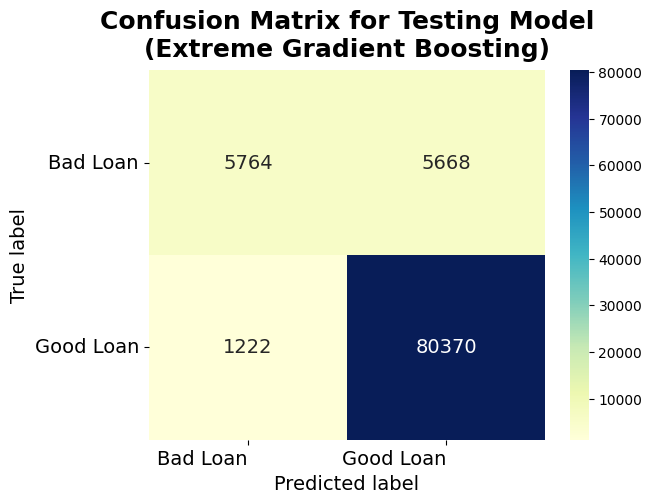

In [65]:
# Form confusion matrix as DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('Bad Loan', 'Good Loan'), ('Bad Loan', 'Good Loan'))

# Plot the confusion matrix
plt.figure()

heatmap = sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {'size': 14}, fmt = 'd', cmap = 'YlGnBu')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)

plt.title('Confusion Matrix for Testing Model\n(Extreme Gradient Boosting)', pad = 10, fontsize = 18, fontweight = 'bold')

plt.ylabel('True label'     , fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

plt.show()

In [66]:
# Extracting the names of features selected in the final stage of the pipeline
ohe = pipeline.named_steps['preprocessor'].named_transformers_['onehot_encoder']
ohe_feature_names = ohe.get_feature_names_out(columns_non_binary)

le_feature_names = columns_binary

numeric_feature_names = columns_numeric

all_feature_names = np.concatenate([ohe_feature_names, le_feature_names, numeric_feature_names])

mask = pipeline.named_steps['features_selector'].get_support()
selected_features = all_feature_names[mask]

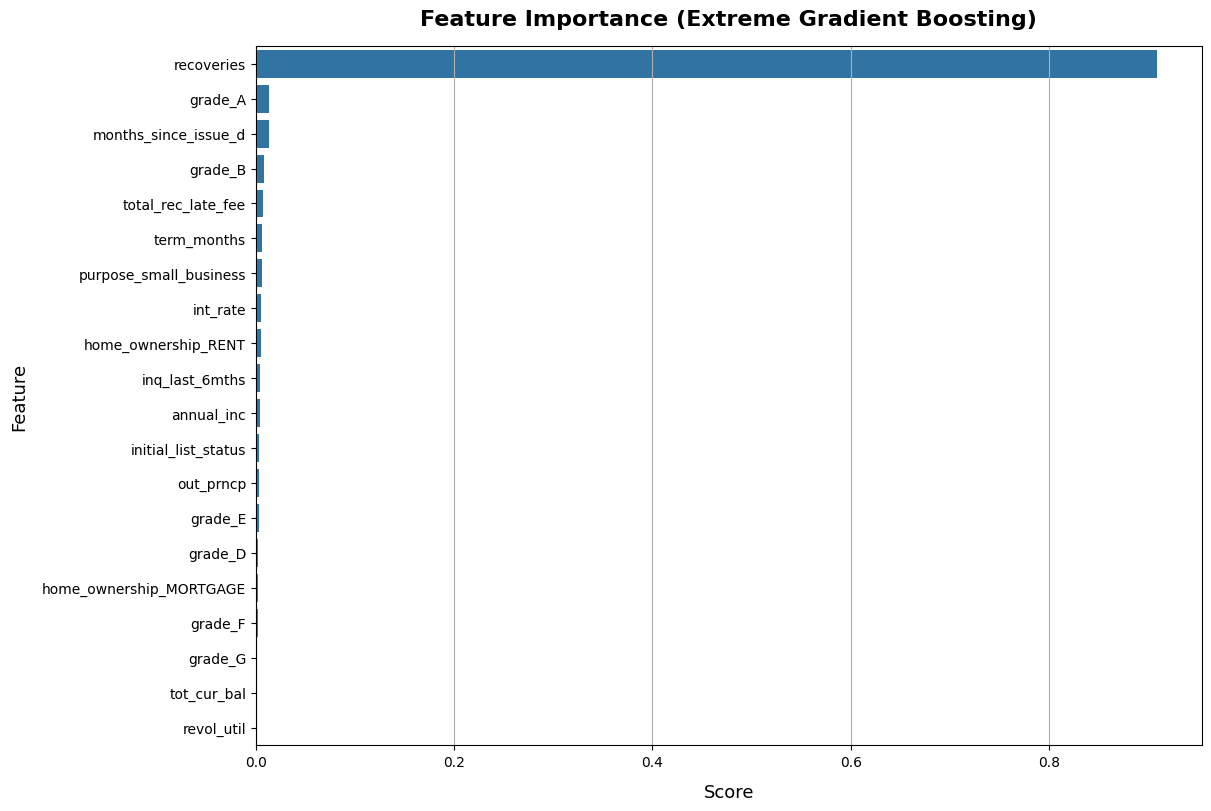

In [67]:
# Get the feature importance
best_model = xgb_tuned_model.best_estimator_
importance = best_model.feature_importances_

# Form feature importance as DataFrame
fi_df = pd.DataFrame({
    'Feature': selected_features,
    'Score'  : importance
}).sort_values(by = 'Score', ascending = False)

# Plot the feature importance
plt.figure(figsize = (12,8), constrained_layout = True)

sns.barplot(data = fi_df, x = 'Score', y = 'Feature')

plt.title('Feature Importance (Extreme Gradient Boosting)', pad = 15, fontsize = 16, fontweight = 'bold')

plt.xlabel('Score'  , labelpad = 10, fontsize = 13)
plt.ylabel('Feature', labelpad = 10, fontsize = 13)

plt.grid(axis = 'x')

plt.show()

# **Conclusions**

<ul style="font-family: 'Georgia', serif; text-align: justify; line-height: 1.5;">
  <li> Model terbaik yang digunakan untuk memprediksi status pinjaman dalam proyek ini adalah <b>Extreme Gradient Boosting (XGBoost)</b>. Pada tahap awal, model dasar (base model) berhasil mencapai tingkat akurasi sebesar <b>92.4%</b>, yang kemudian meningkat menjadi <b>92.6%</b> setelah dilakukan hyperparameter tuning. </li>

  <li> Berdasarkan hasil pemodelan, diperoleh lima fitur teratas yang memiliki pengaruh langsung terhadap status pinjaman, yaitu <b>recoveries</b>, <b>grade</b>, <b>months_since_issue_d</b>, <b>total_rec_late_fee</b>, dan <b>term</b>. </li>
</ul>